### **Study notes - Time series modelling**

_Based on_

_https://online.stat.psu.edu/stat510/ and_

_Shumway, R., Stoffer, D. (2011). Time series analysis and its applications, with R examples, 3rd edition. Springer New York Dordrecht Heidelberg London. e-ISBN 978-1-4419-7865-3_

These notes aim to explain some basic principles of time series modelling in a practical way, but without avoiding critical theoretical details. It's a summary of (hopefully) **understandable explanations** of key ideas, and not just a plain presentation of concepts, which is often what I've found (and struggled with) in many textbooks.

#### **1. What are time series, and why are they different from other data sets?**

A time series is just a sequence of measurements of a variable (GDP, wind speed, population size, no. users, no. transactions, etc.) over time, where every data point has a time associated with it (typically called a 'time stamp'). Here's a manual example:

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.linear_model import LinearRegression

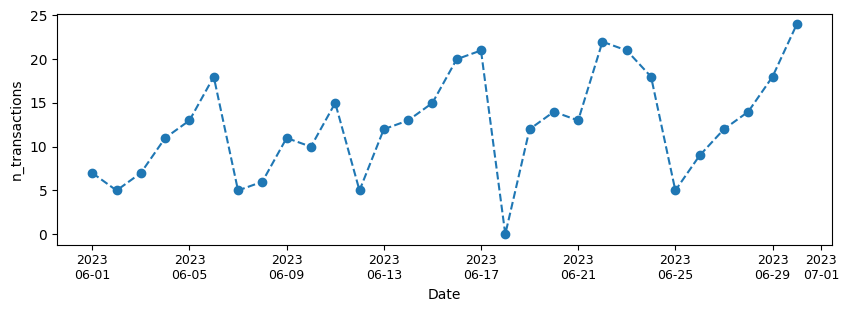

In [65]:
daily_transactions = pd.DataFrame({
    'date': pd.date_range(start='2023-06-01', end='2023-06-30', freq='D'),
    'n': [7, 5, 7, 11, 13, 18, 5, 6, 11, 10, 15, 5, 12, 13, 15, 20, 21, 0, 12, 14, 13, 22, 21, 18, 5, 9, 12, 14, 18, 24],
})

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(daily_transactions['date'], daily_transactions['n'], linestyle='--', marker='o')
ax.set_ylabel('n_transactions')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%m-%d'))
ax.tick_params(axis='x', labelsize=9)
ax.set_xlabel('Date')
plt.show()

When variables are measured over time, data points that are close to each other are unlikely to be independent. This non-independence prevents the use classical statistical approaches (OLS, ANOVA, etc.) to model temporal trends in this data. For instance, regressing a variable $y$, which we have measured over time, onto time $t$ using a model like $y = \beta_0 + \beta_1t + \epsilon$ would very likely have _autocorrelated_ residuals due to their temporal proximity. With the above data, that would look like this:

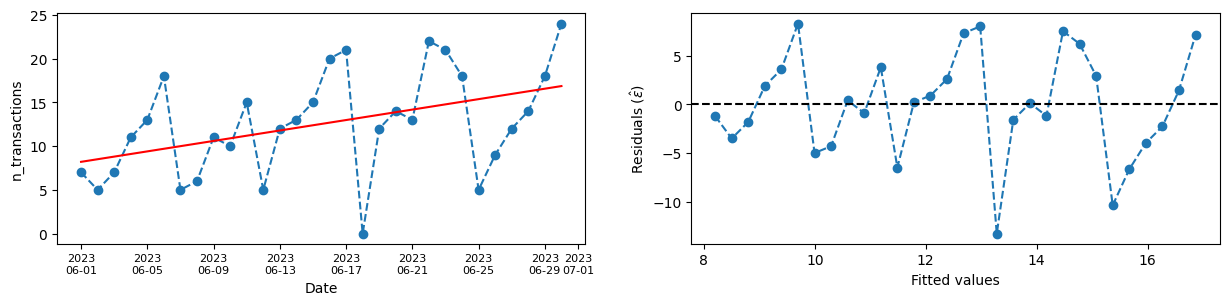

In [68]:
daily_transactions['date_num'] = (daily_transactions['date'] - pd.to_datetime('2023-06-01')).dt.days

X = daily_transactions['date_num'].values.reshape(-1, 1) 
y = daily_transactions['n'].to_numpy()

model = LinearRegression()
model.fit(X, y)
ypred = model.predict(X)
epsilon_hat = y - ypred 

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].plot(daily_transactions['date'], daily_transactions['n'], linestyle='--', marker='o', label='data')
ax[0].plot(daily_transactions['date'], ypred, color='red', label='model')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('n_transactions')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%m-%d'))
ax[0].tick_params(axis='x', labelsize=8)
ax[1].plot(ypred, epsilon_hat, marker='o', linestyle='--')
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel(r'Residuals ($\hat{\epsilon})$')
plt.show()

Clearly, residuals are autocorrelated, so a simple OLS doesn't work because we'd violate the assumption of independent residuals. The strong residual autocorrelation also indicates there's something major missing from the OLS model, namely the fact that datapoints are **not independent** in time.